## Laboratorium 12

## Ocena podobieństwa elementów wizualnych za pomocą _triple nets_

#### Wstęp

W pewnej klasie zadań możemy nie dysponować konkretnymi etykietami dla danych, lecz zbiór jest ustrukturyzowany w taki sposób, że dysponujemy kilkoma przykładami dla każdej _instancji_. Do klasy tej należą zadania takie jak np. identyfikacja twarzy (dane jest wiele różnych osób, ale dla każdej z nich mamy niewielką liczbę obrazów uczących), czy wyszukiwania obszarów podobnych (dany jest element wizualny, należy znaleźć podobne mu obrazy) - szerzej: gdy liczba klas jest duża, a przykładów dla każdej z nich jest niewiele.

Podejście klasyfikacyjne do takich problemów nie zawsze się udaje - nauczenie klasyfikatora, gdy dla pewnej klasy mamy ledwie 2 czy 3 obrazy, stanowi duże wyzwanie. W tych sytuacjach często stosuje się podejście uczenia podobieństwa. Wykorzystuje się w tym celu różne warianty sieci syjamskich (_Siamese networks_) czy trójkowych (_triple nets_); na laboratorium przetestujemy podstawowe podejście bazujące na triple necie wg Schroff et al. - _FaceNet: A Unified Embedding for Face Recognition and Clustering_ (2015) [[1](https://arxiv.org/abs/1503.03832)].

Metody te łączy fakt, że uczymy nie klasyfikator, który w jakiś sposób "tnie" wysokowymiarową przestrzeń danych na podobszary-klasy, ale enkoder, osadzający (_embedding_) próbki w takiej przestrzeni, że przykłady podobne sobie wizualnie znajdują się w tej przestrzeni "blisko siebie" (wg jakiejś przyjętej miary odległości).

#### Triplet loss

Załóżmy, że mamy pewną sieć konwolucyjną (_backbone_), która tworzy wektorowe reprezentacje dla podanych obrazów. Chcemy nauczyć ją w taki sposób, by reprezentacje obrazów sobie podobnych leżały "blisko" w przestrzeni reprezentacji. Musimy zatem zaproponować taką funkcję kosztu, która będzie ten cel realizować. Podejście, którym zajmiemy się na zajęciach, oparte jest o funkcję kosztu zwaną _triplet loss_. Intuicja za nią jest następująca:
* wybieramy losowy obraz z datasetu, $A$ (od _anchor_),
* wybieramy losowy obraz z **tej samej klasy**, $P$ (_positive_),
* wybieramy losowy obraz z **innej** klasy, $N$ (_negative_),
* propagujemy gradienty w taki sposób, by minimalizować odległość (wg jakiejś przyjętej metryki $D$) między $A$ i $P$, a zarazem maksymalizować odległość między $A$ i $N$.

Matematycznie, funkcja triplet loss wyraża się w następujący sposób:
$$L_{triplet} = \max(\Vert f(x_A)^2 - f(x_P)^2\Vert_{2}^2 - \Vert f(x_A)^2 - f(x_N)^2\Vert_{2}^2 + \alpha; 0)$$
gdzie $f(x)$ jest funkcją enkodującą próbkę $x$ (a więc obraz) do przestrzeni reprezentacji (a więc naszą siecią backbone), a $\Vert v \Vert_{2}^2$ oznacza długość wektora $v$ według metryki Euklidesowej. Wspomnieć należy, że można przyjmować różne miary odległości. $\alpha$ stanowi zaś _margines_ - minimalną (dodatnią) wartość różnicy w odległości, dla której wartość funkcji wynosi zero. Zadaniem marginesu jest ograniczenie wpływu łatwych przypadków, które już leżą bardzo blisko siebie i łatwo byłoby je jeszcze bardziej przybliżać; dzięki wyzerowaniu funkcji kosztu dla takich przypadków, sieć uczy się tylko z par "trudnych". W praktyce wystarczy zaś, by podobne próbki leżały w odległości właśnie poniżej tego marginesu - jeśli tylko próbki różne będą wystarczająco rozdzielone.

#### Normalizacja

W podejściu _triple net_ embeddingi wytworzone przez sieć konwolucyjną poddaje się normalizacji $L2$ (przed obliczeniem dystansów i funkcji straty). Dzięki temu uzyskuje się proporcjonalność odległości $L2$ między embeddingami do ich podobieństwa cosinusowego (co można [łatwo udowodnić](https://en.wikipedia.org/wiki/Cosine_similarity#Properties)). Powoduje to, że embeddingi umieszczane są na powierzchni $d$-wymiarowej hipersfery (gdzie $d$ jest wymiarem przestrzeni osadzeń - jest to parametr metody, którego wartość musimy przyjąć).

Podany wyżej wzór na $L_{triplet}$ ze względu na swoją złożoność nie zawiera normalizacji, której należy poddać każdy z elementów $f(x_i)$.

### Uczenie

Naturalną różnicą pomiędzy podejściem triple net a np. klasyfikacją jest konieczność losowania trójek obrazów z datasetu. Może to nastręczać pewnych kłopotów przy implementacji - zwłaszcza, jeśli zainteresujemy się podejściami typu [_hard mining_](https://omoindrot.github.io/triplet-loss#triplet-mining): w skrócie, wyszukiwanie najtrudniejszych przypadków, dla których różnica w odległościach będzie największa (a więc bardzo odległych od siebie pozytywów i bardzo bliskich negatywów). Dla uproszczenia pominiemy kwestię metody doboru sampli, choć w praktyce ma ona duży wpływ na dynamikę uczenia i finalną jakość modelu.

Pełen pipeline wyglądać zatem będzie następująco:
* pobieramy trójkę $A$, $P$, $N$ z datasetu,
* wykorzystujemy dowolną wstępnie nauczoną sieć konwolucyjną do obliczenia embeddingów dla wylosowanych obrazów  
(uwaga: o ile część konwolucyjną możemy zamrozić na potrzeby uczenia, komponent _fully connected_ musi zostać nauczony od nowa!),
* normalizujemy embeddingi ($L2$),
* obliczamy wartość funkcji kosztu $L_{triplet}$.

Klasa `TripletDataset` owijająca zwykły dataset w taki sposób, by generować trójki zgodnie z metodą, jest dołączona do instrukcji. Podobnie, dana jest klasa `Normalize`. Funkcję kosztu [`TripletMarginWithDistanceLoss`](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss) znajdziesz w dokumentacji PyTorch.

W zadaniu korzystać będziemy z datasetu CIFAR100 ze względu na jego niewielki, ale wystarczający rozmiar, dużą liczbę klas (100), oraz dostępność w module [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.CIFAR100).

In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision as tv
import torchvision.models as M
import torchvision.transforms as T

from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
class TripletDataset(torch.utils.data.Dataset):
  """Wrapper dataset that draws triplets from the source_dataset.
  
  size: arbitrary 'length' of dataset, number of triplets to draw in one epoch
  """
  def __init__(self, source_dataset, size:int):
    super(TripletDataset, self).__init__()
    self.class_bags = [[] for _ in source_dataset.classes]
    for image, label in source_dataset:
      self.class_bags[label].append(image)
    self.count = sum(len(bag) for bag in self.class_bags)
    self.size = size
    self.ncls = len(self.class_bags)

  def __len__(self):
    return self.size

  def __getitem__(self, i):
    return self.get_random_triplet()

  def get_random_triplet(self):
    anchor_class = random.randint(0, self.ncls-1)
    anchor = random.choice(self.class_bags[anchor_class])
    positive = random.choice(self.class_bags[anchor_class])
    negative_class = random.randint(0, self.ncls-2)
    if negative_class >= anchor_class:
      negative_class += 1
    negative = random.choice(self.class_bags[negative_class])
    return anchor, positive, negative

In [3]:
data_transform = T.Compose([
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  # T.Resize(size=100),
])

In [4]:
cifar_train = tv.datasets.CIFAR100(root='content', train=True, download=True, transform=data_transform)

Files already downloaded and verified


In [5]:
train_3loader = TripletDataset(cifar_train, 10000)
train_loader = DataLoader(train_3loader, 64, pin_memory=True)

---

### Zadanie 1 (2.0 pkt | 1.0 pkt)

Uzupełnij pętlę uczenia dla metody triple net wg algorytmu podanego we wstępie.

Wybierz pretrenowany backbone konwolucyjny, usuwając jego ostatni moduł ("klasyfikator") i dostawiając nowy moduł `Linear` o porównywalnej (64-512) liczbie wyjść (tj. wymiar przestrzeni embeddingu). Przeprowadź proces uczenia modelu z parametrami optymalizatora (_learning rate_, liczba epok) dobranymi "na oko" - tzn. to nie jest najważniejsza część laboratorium, uczenie nie ma zająć Ci dużo czasu.

In [6]:
class Normalize(torch.nn.Module):
  def __init__(self, p:float):
    super(Normalize, self).__init__()
    self.p = p
  def forward(self, x):
    return torch.nn.functional.normalize(x, p=self.p, dim=1)


def epoch(backbone, head, data_lodaer, optim, device='cuda'):
  loss_fun = torch.nn.TripletMarginLoss()
  normalize = Normalize(2.0)
  avg_loss = 0.0
  n_batches = 0
  for anchors, positives, negatives in data_lodaer:
    with torch.no_grad():
      embed_a, embed_p, embed_n = backbone(anchors.to(device)), backbone(positives.to(device)), backbone(negatives.to(device))
    embed_a, embed_p, embed_n = head(embed_a), head(embed_p), head(embed_n)
    embed_a, embed_p, embed_n = normalize(embed_a), normalize(embed_p), normalize(embed_n)
    loss = loss_fun(embed_a, embed_p, embed_n)
    loss.backward()
    
    optim.step()
    optim.zero_grad()
    avg_loss += loss.item()
    n_batches += 1
  return avg_loss / n_batches

In [7]:
net = M.resnet18(pretrained=True)
net.fc = torch.nn.Identity()
head = torch.nn.Linear(512, 512)

In [8]:
device = 'cuda'
net.to(device)
head.to(device)
optimizer = torch.optim.Adam(head.parameters(), lr=0.001)
for i in tqdm(range(20)):
  loss = epoch(net, head, train_loader, optimizer, device)
  print(loss)

  5%|▌         | 1/20 [00:04<01:31,  4.82s/it]

0.859655007435258


 10%|█         | 2/20 [00:06<01:11,  3.99s/it]

0.778278147718709


 15%|█▌        | 3/20 [00:09<00:58,  3.44s/it]

0.7651743691438323


 20%|██        | 4/20 [00:11<00:48,  3.02s/it]

0.7510568491972176


 25%|██▌       | 5/20 [00:12<00:40,  2.69s/it]

0.7302716438937339


 30%|███       | 6/20 [00:14<00:34,  2.47s/it]

0.7366444658321939


 35%|███▌      | 7/20 [00:16<00:30,  2.32s/it]

0.7404137295522507


 40%|████      | 8/20 [00:18<00:26,  2.22s/it]

0.72826779534103


 45%|████▌     | 9/20 [00:20<00:23,  2.13s/it]

0.7360889076427289


 50%|█████     | 10/20 [00:22<00:20,  2.08s/it]

0.7200369193295765


 55%|█████▌    | 11/20 [00:24<00:18,  2.04s/it]

0.7223512446804411


 60%|██████    | 12/20 [00:26<00:16,  2.02s/it]

0.7251062450135589


 65%|██████▌   | 13/20 [00:28<00:14,  2.00s/it]

0.7273418781863656


 70%|███████   | 14/20 [00:30<00:12,  2.00s/it]

0.7312251420537378


 75%|███████▌  | 15/20 [00:32<00:10,  2.01s/it]

0.7301092933697305


 80%|████████  | 16/20 [00:34<00:08,  2.01s/it]

0.7243491301111354


 85%|████████▌ | 17/20 [00:36<00:06,  2.03s/it]

0.7284223627132974


 90%|█████████ | 18/20 [00:38<00:04,  2.05s/it]

0.7221020638563072


 95%|█████████▌| 19/20 [00:41<00:02,  2.09s/it]

0.7258156659496817


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]

0.7226136960801045


### Komentarz 1

Jak widać model się uczy, dochodząc do ~0.7225 wartości funkcji straty. Użyłem wyjścia o wymiarze 512, ale wyniki nie różnią się dla mniejjszych wymiarów.

---

### Zadanie 2 (1.0 pkt | 1.0 pkt)

Przetestuj nauczony model w następujący sposób: wybierz z datasetu (testowego!) kilka dowolnych przykładów z różnych klas, a następnie przeszukaj resztę datasetu, dla każdego z nich wyciągając kilka (5-10) najbliższych (wg. przyjętego dystansu w przestrzeni osadzeń) obrazów.

Wyniki przedstaw graficznie, sprawdź też czy znalezione obrazy należą do tych samych klas.

Nie chodzi o wyczerpujące przejrzenie datasetu i liczenie metryk, tylko wizualną ocenę. _Jeśli bardzo chcesz_, możesz wykonać dodatkowy eksperyment z klasteryzacją embeddingów, ale nie jest to część zadania.

In [9]:
cifar_test = tv.datasets.CIFAR100(root='content', train=False, download=False, transform=data_transform)

In [10]:
image, cid = cifar_test[0] # zwraca już krotkę (tensor CxHxW, int)
# aby propagować przez sieć neuronową:
# out = net(image[None, ...].to(device))
# aby powrócić do formatu OpenCV (float32 BGR)
image = np.clip(image.numpy()[::-1, ...].transpose((1,2,0)) * np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406]), 0.0, 1.0)

In [11]:
import matplotlib.pyplot as plt

In [12]:
def restore_img(image: torch.Tensor):
    return np.clip(image.cpu().numpy()[::-1, ...].transpose((1,2,0)) * np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406]), 0.0, 1.0)

100%|██████████| 157/157 [00:01<00:00, 82.72it/s]


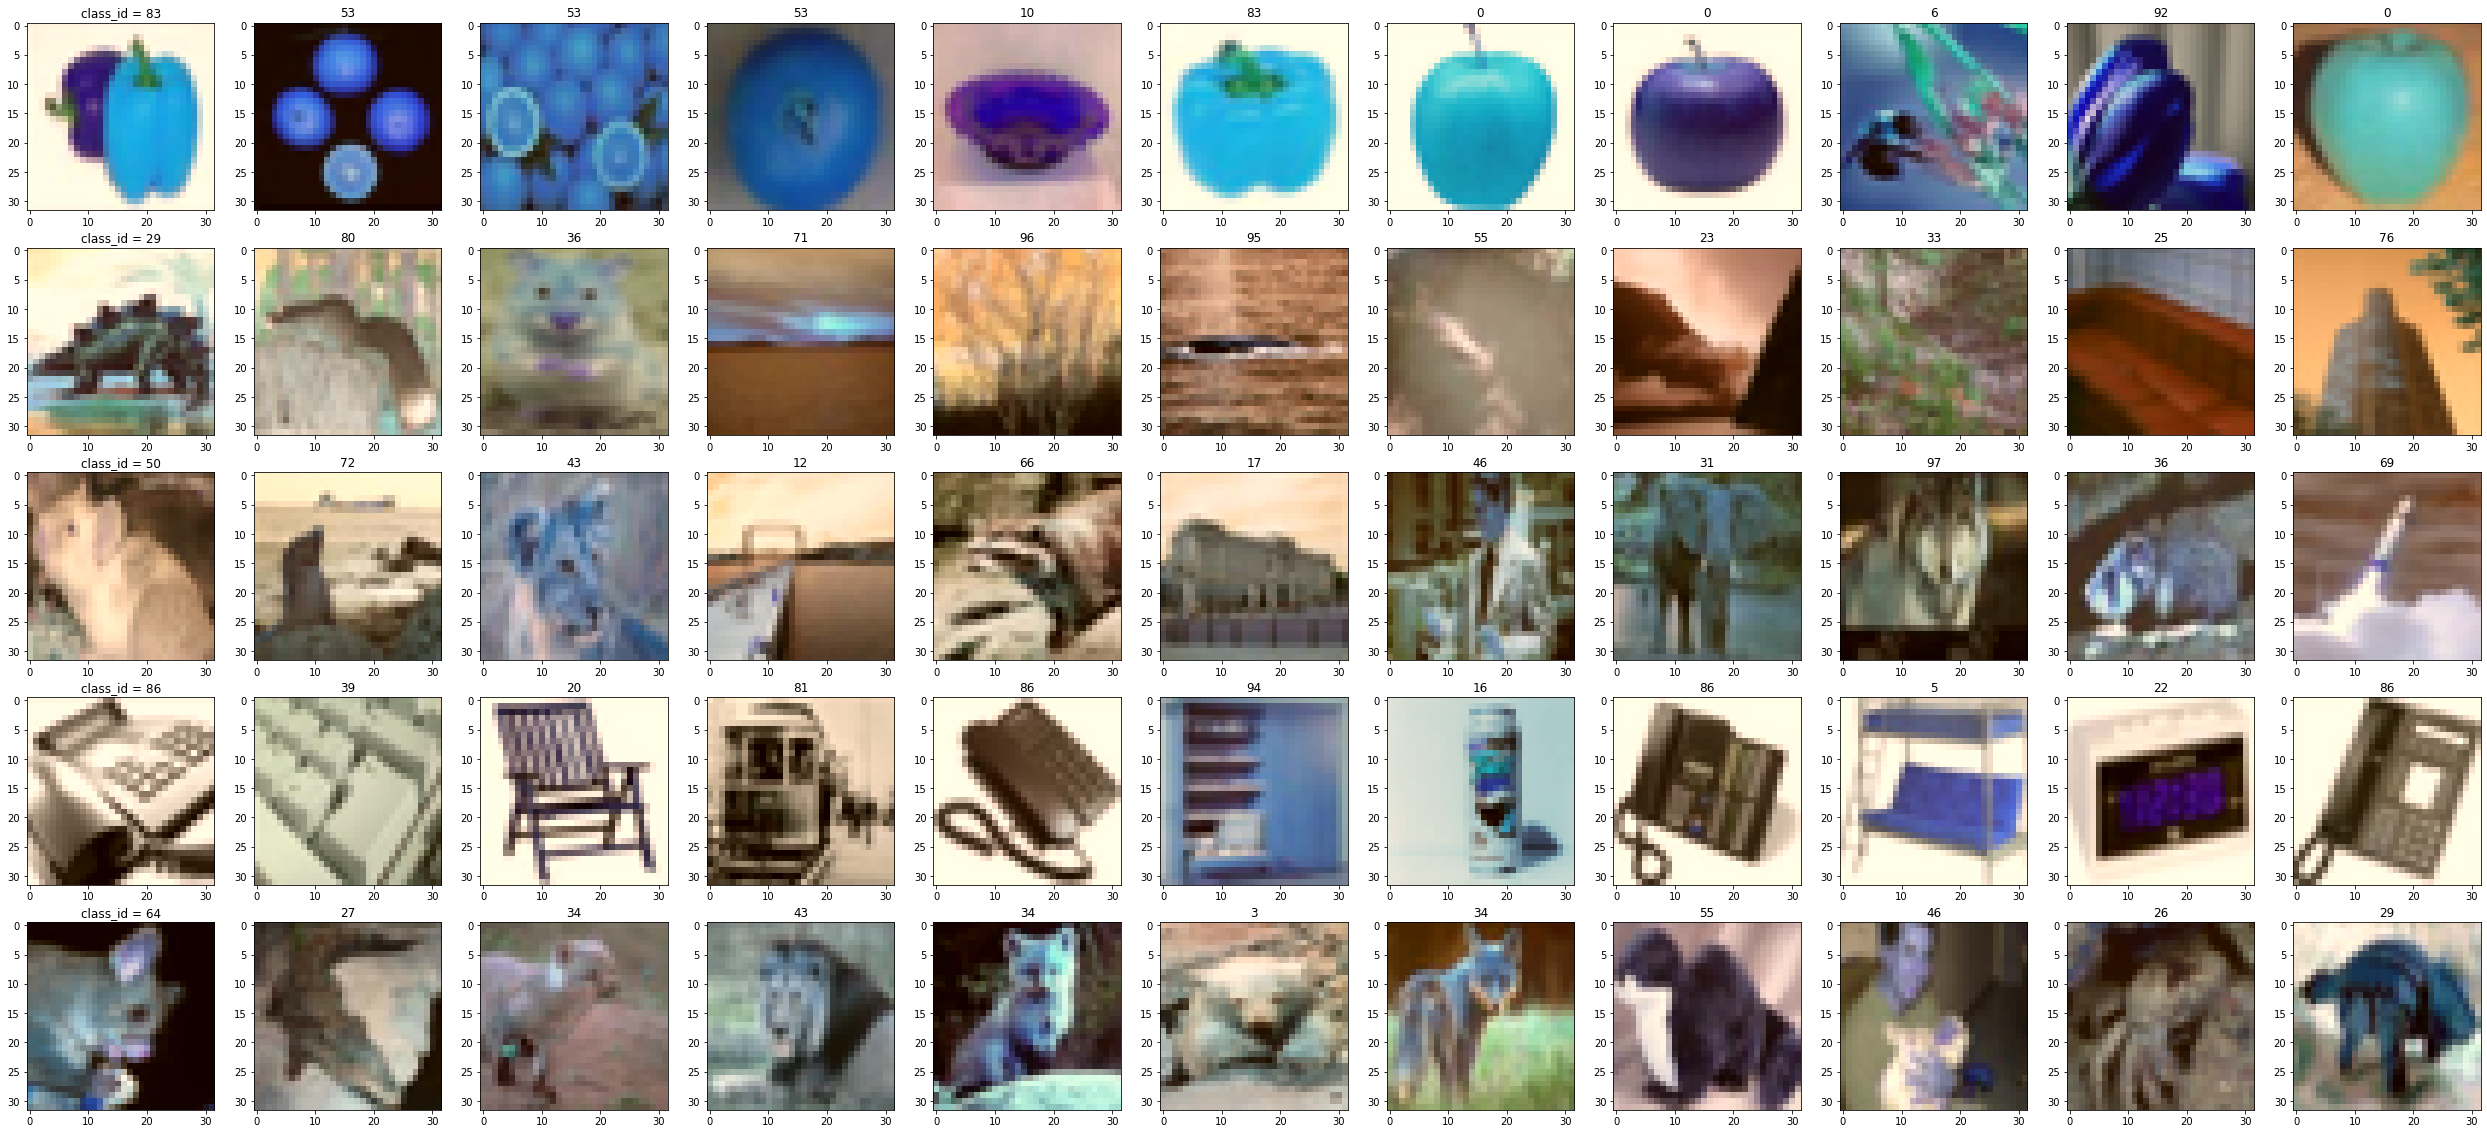

In [29]:
no_samples = 5
no_matches = 10

samples = []
sample_cids = []
while len(samples) < no_samples:
    img, cid = random.choice(cifar_test)
    if cid not in sample_cids:
        samples.append(img)
        sample_cids.append(cid)

test_dl = DataLoader(cifar_test, 64, pin_memory=True)

net.eval()
head.eval()
normalize = Normalize(2.0)
dist = torch.nn.PairwiseDistance()
distances = [[] for _ in range(no_samples)]
cids = []
with torch.no_grad():
    sample_embeddings = normalize(head(net(torch.stack(samples).to(device))))
    sample_batches = sample_embeddings
    for X_batch, y_batch in tqdm(test_dl):
        emb = normalize(head(net(X_batch.to(device))))

        if sample_batches.shape[1] != X_batch.shape[0]:
            sample_batches = torch.stack([sample_embeddings for _ in range(X_batch.shape[0])], dim=1)
        
        for i in range(no_samples):
            distances[i].append(dist(sample_batches[i], emb))
        cids.append(y_batch)

    closest = [[] for _ in range(no_samples)]
    closest_cids = [[] for _ in range(no_samples)]
    for i in range(no_samples):
        distances[i] = torch.cat(distances[i]).cpu()
        closest[i] = torch.topk(distances[i], no_matches + 1, largest=False)[1][1:]

fig, axs = plt.subplots(no_samples, no_matches + 1, figsize=((no_matches + 1) * 4, no_samples * 4))
for y in range(no_samples):
    axs[y, 0].imshow(restore_img(samples[y]))
    axs[y, 0].set_title('class_id = ' + str(sample_cids[y]))
    for x in range(no_matches):
        img, cid = cifar_test[closest[y][x]]
        axs[y, x + 1].imshow(restore_img(img))
        axs[y, x + 1].set_title(str(cid))

### Komentarz 2

W pierwszej kolumnie znajdują się wylosowane obrazy, a w pozostałych te o embedingach najbliższych do wylosowanych (najbliższe po lewej).

Jak widać wyniki są mieszane. Model rzadko kiedy znajdywał te same klasy. Z drugiej strony w większości przypadków istnieje wyraźne podobieństwo lub wspólne cechy między wzorcem i dobranymi obrazami. Jest to szczególnie widoczne w pierwszym wierszu, gdzie do niebieskiej papryki dobrał inne okrągłe niebieskie owoce i warzywa.
W czwartym wierszu wybierał ciemniejsze obiekty na białym tle i znalazł też kilka telefonów. W ostatnim wierszu dobrał w większości inne zdjęcia zwierząt.

Podsumowując o ile model kiepsko dobierał klasy, to w większości przypadków widać podobieństwa które wymusiły bliskość embeddingów. Jednym z możliwych powodów niedokładności może być niska rozdzielczość obrazów.